# 라이브러리 호출

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import math
import random
import os
import seaborn as sns
import cv2
import hiddenlayer as hl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support

from imblearn.over_sampling import SMOTE
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchviz import make_dot

torch.backends.cudnn.enabled = False

In [2]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Kaggle 데이터 불러오기 

In [3]:
# 데이터 로드
loaded_kaggle_x_data = np.load('kaggle_x_data.npy', allow_pickle=True)
loaded_kaggle_y_data = np.load('kaggle_y_data.npy', allow_pickle=True)

# 로드된 데이터의 모양 확인
print("Loaded kaggle_x_data shape:", loaded_kaggle_x_data.shape)  # 출력: (1409, 150, 6)
print("Loaded kaggle_y_data shape:", loaded_kaggle_y_data.shape)

Loaded kaggle_x_data shape: (1704, 150, 6)
Loaded kaggle_y_data shape: (1704,)


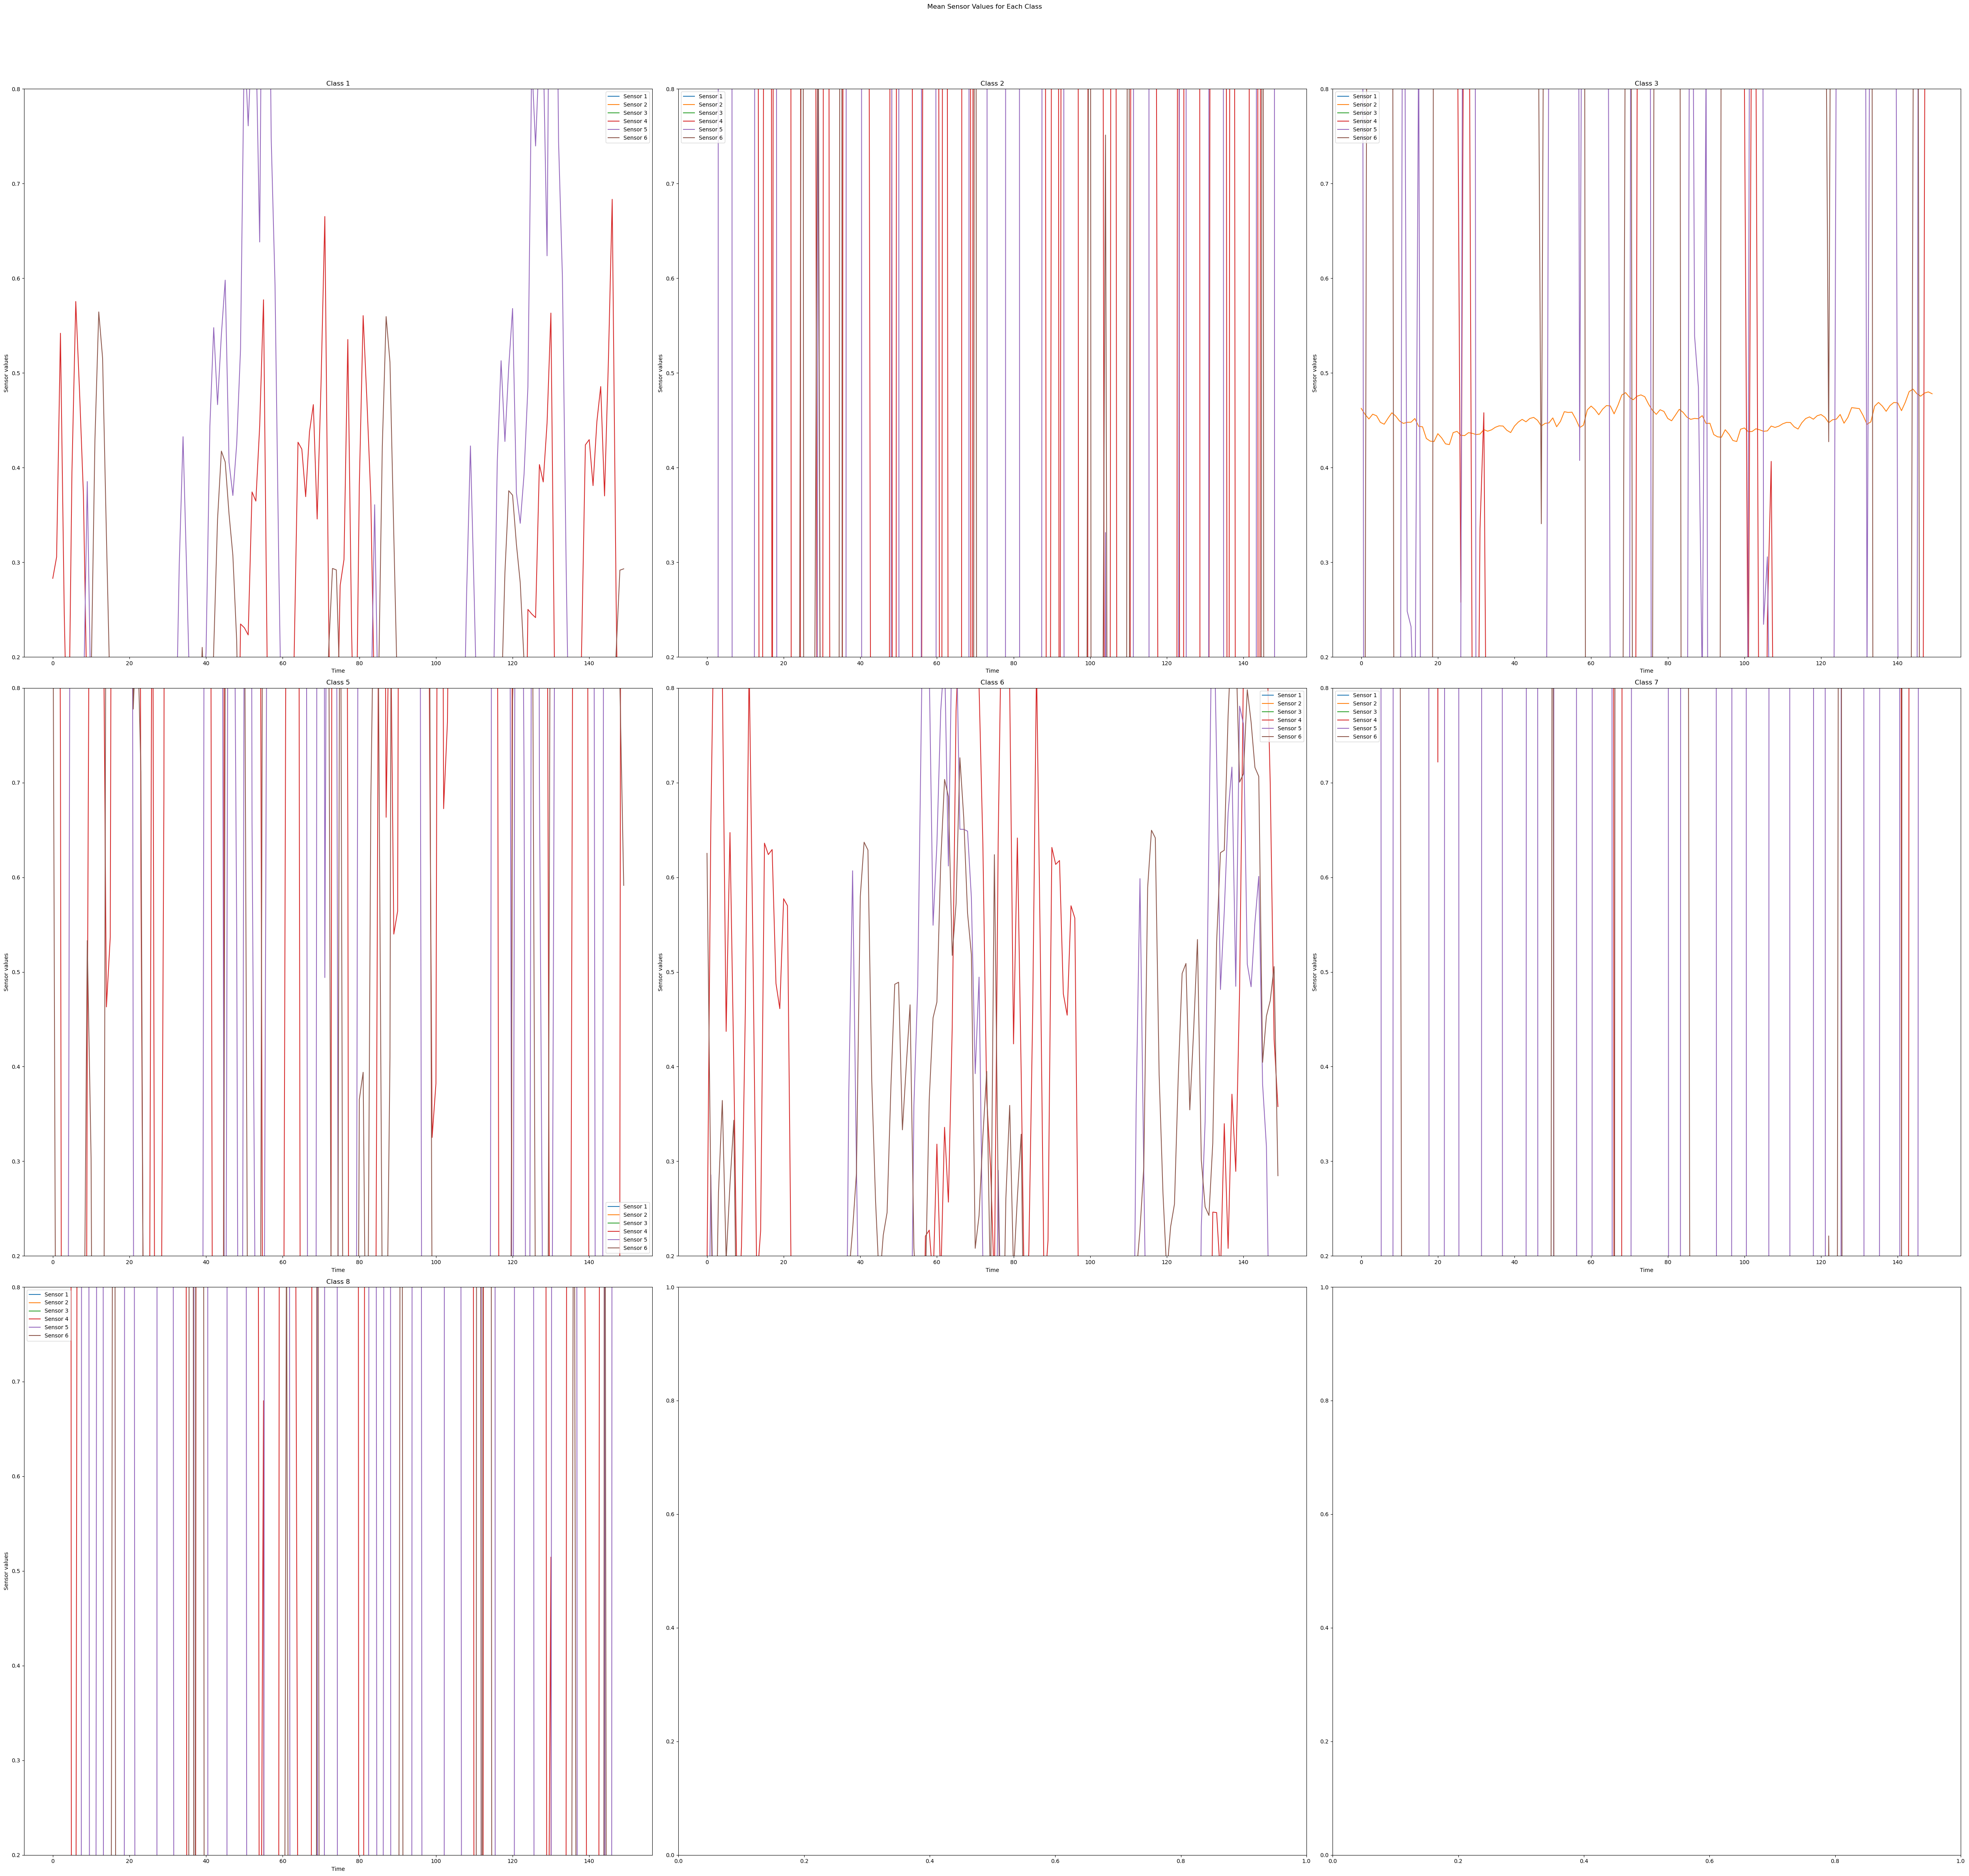

In [4]:
unique_classes = np.unique(loaded_kaggle_y_data)
num_axes = 6  # 6축 센서 데이터
num_rows = 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(50,50))
fig.suptitle("Mean Sensor Values for Each Class")

for idx, cls in enumerate(unique_classes):
    row = idx // num_cols
    col = idx % num_cols

    ax = axes[row][col]  # 수정된 부분

    # 각 클래스별 인덱스 찾기
    class_indices = np.where(loaded_kaggle_y_data == cls)

    # 클래스별 데이터 추출
    class_data = loaded_kaggle_x_data[class_indices]

    # 각 센서 축별 평균값 계산 및 시각화
    for axis in range(num_axes):
        # 축별 데이터 추출
        axis_data = class_data[:, :, axis]

        # 평균값 계산
        mean_values = np.mean(axis_data, axis=0)

        # 평균값 시각화
        ax.plot(mean_values, label=f"Sensor {axis+1}")

    ax.set_title(f"Class {cls}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Sensor values")
    ax.set_ylim([0.2, 0.8])  # y축 범위 지정
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 서브플롯 간격 및 전체 플롯 제목 간격 조정
plt.show()


In [5]:
kaggle_xtrain_count = np.isnan(loaded_kaggle_x_data).sum()
print(f"Number of NaN values in kaggle_xtrain_count: {kaggle_xtrain_count}")

Number of NaN values in kaggle_xtrain_count: 0


# DMLAB 데이터 불러오기

In [6]:
# 데이터 로드
loaded_dmlab_x_data = np.load('dmlab_x_data.npy', allow_pickle=True)
loaded_dmlab_y_data = np.load('dmlab_y_data.npy', allow_pickle=True)

# 로드된 데이터의 모양 확인
print("Loaded dmlab_x_data shape:", loaded_dmlab_x_data.shape)  # 출력: (1409, 150, 6)
print("Loaded dmlab_y_data shape:", loaded_dmlab_y_data.shape)

Loaded dmlab_x_data shape: (10864, 150, 6)
Loaded dmlab_y_data shape: (10864,)


In [7]:
dblab_xtrain_count = np.isnan(loaded_dmlab_x_data).sum()
print(f"Number of NaN values in dblab_xtrain_count: {dblab_xtrain_count}")

Number of NaN values in dblab_xtrain_count: 2144


# 데이터 합치기

In [8]:
# 두 데이터셋을 합칩니다.
merged_x_data = np.concatenate((loaded_kaggle_x_data, loaded_dmlab_x_data), axis=0)
merged_y_data = np.concatenate((loaded_kaggle_y_data, loaded_dmlab_y_data), axis=0)

# 합쳐진 데이터의 모양을 확인합니다.
print("Merged x_data shape:", merged_x_data.shape)  # 출력: (9347, 150, 6)
print("Merged y_data shape:", merged_y_data.shape)  # 출력: (9347,)

Merged x_data shape: (12568, 150, 6)
Merged y_data shape: (12568,)


In [9]:
unique_classes = np.unique(merged_y_data)
num_axes = 6  # 6축 센서 데이터
num_rows = 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(200,100))
fig.suptitle("Mean Sensor Values for Each Class")

for idx, cls in enumerate(unique_classes):
    row = idx // num_cols
    col = idx % num_cols

    ax = axes[row][col]  # 수정된 부분

    # 각 클래스별 인덱스 찾기
    class_indices = np.where(merged_y_data == cls)

    # 클래스별 데이터 추출
    class_data = merged_x_data[class_indices]

    # 각 센서 축별 평균값 계산 및 시각화
    for axis in range(num_axes):
        # 축별 데이터 추출
        axis_data = class_data[:, :, axis]

        # 평균값 계산
        mean_values = np.mean(axis_data, axis=0)

        # 평균값 시각화
        ax.plot(mean_values, label=f"Sensor {axis+1}")

    ax.set_title(f"Class {cls}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Sensor values")
    ax.set_ylim([0.2, 0.8])  # y축 범위 지정
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 서브플롯 간격 및 전체 플롯 제목 간격 조정
plt.show()


In [ ]:
# 결측값이 있는 인덱스를 찾습니다.
nan_indices = np.argwhere(np.isnan(merged_x_data))

# 유일한 인덱스를 얻기 위해 세트를 사용합니다.
unique_nan_indices = set(nan_indices[:, 0])

# 결측값이 없는 인덱스를 찾습니다.
non_nan_indices = [index for index in range(merged_x_data.shape[0]) if index not in unique_nan_indices]

# 결측값이 없는 데이터만 필터링합니다.
merged_x_data = merged_x_data[non_nan_indices]
merged_y_data = merged_y_data[non_nan_indices]

print("Filtered x_data shape:", merged_x_data.shape)
print("Filtered y_data shape:", merged_y_data.shape)

Filtered x_data shape: (12552, 150, 6)
Filtered y_data shape: (12552,)


In [11]:
# behavior_list를 정수 값과 원-핫 벡터로 변환
values = np.array(merged_y_data)

# LabelEncoder를 사용하여 행동 레이블을 정수로 변환합니다. 이렇게 하면 각 레이블에 고유한 정수가 할당
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

# 변환된 정수 레이블을 2D 배열로 바꾸어 OneHotEncoder에 입력으로 제공
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

# OneHotEncoder를 사용하여 정수 레이블을 원-핫 벡터로 변환
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# 원-핫 인코딩된 행동 레이블을 y_train (total_y_train)으로 사용할 수 있는 형태로 변환
total_y_train = onehot_encoded
print("로드된 y 데이터 길이 : ", np.array(total_y_train).shape)

로드된 y 데이터 길이 :  (12552, 9)


/home/user/anaconda3/envs/Junhyeok/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# 스케일링 진행

In [12]:
unique_classes = np.unique(merged_y_data)
num_axes = 6  # 6축 센서 데이터

for cls in unique_classes:
    # 각 클래스별 인덱스 찾기
    class_indices = np.where(merged_y_data == cls)

    # 클래스별 데이터 추출
    class_data = merged_x_data[class_indices]

    for axis in range(num_axes):
        # 축별 데이터 추출
        axis_data = class_data[:, :, axis]

        # Min-Max 스케일링 객체 생성
        scaler = MinMaxScaler()

        # 데이터셋의 모양에 맞게 데이터를 재구성
        reshaped_data = axis_data.reshape(-1, 1)

        # Min-Max 스케일링 적용
        scaled_data = scaler.fit_transform(reshaped_data)

        # 스케일링 된 데이터를 원래의 모양으로 되돌리기
        scaled_data = scaled_data.reshape(axis_data.shape)

        # 정규화된 데이터를 원래 데이터셋에 저장
        merged_x_data[class_indices, :, axis] = scaled_data

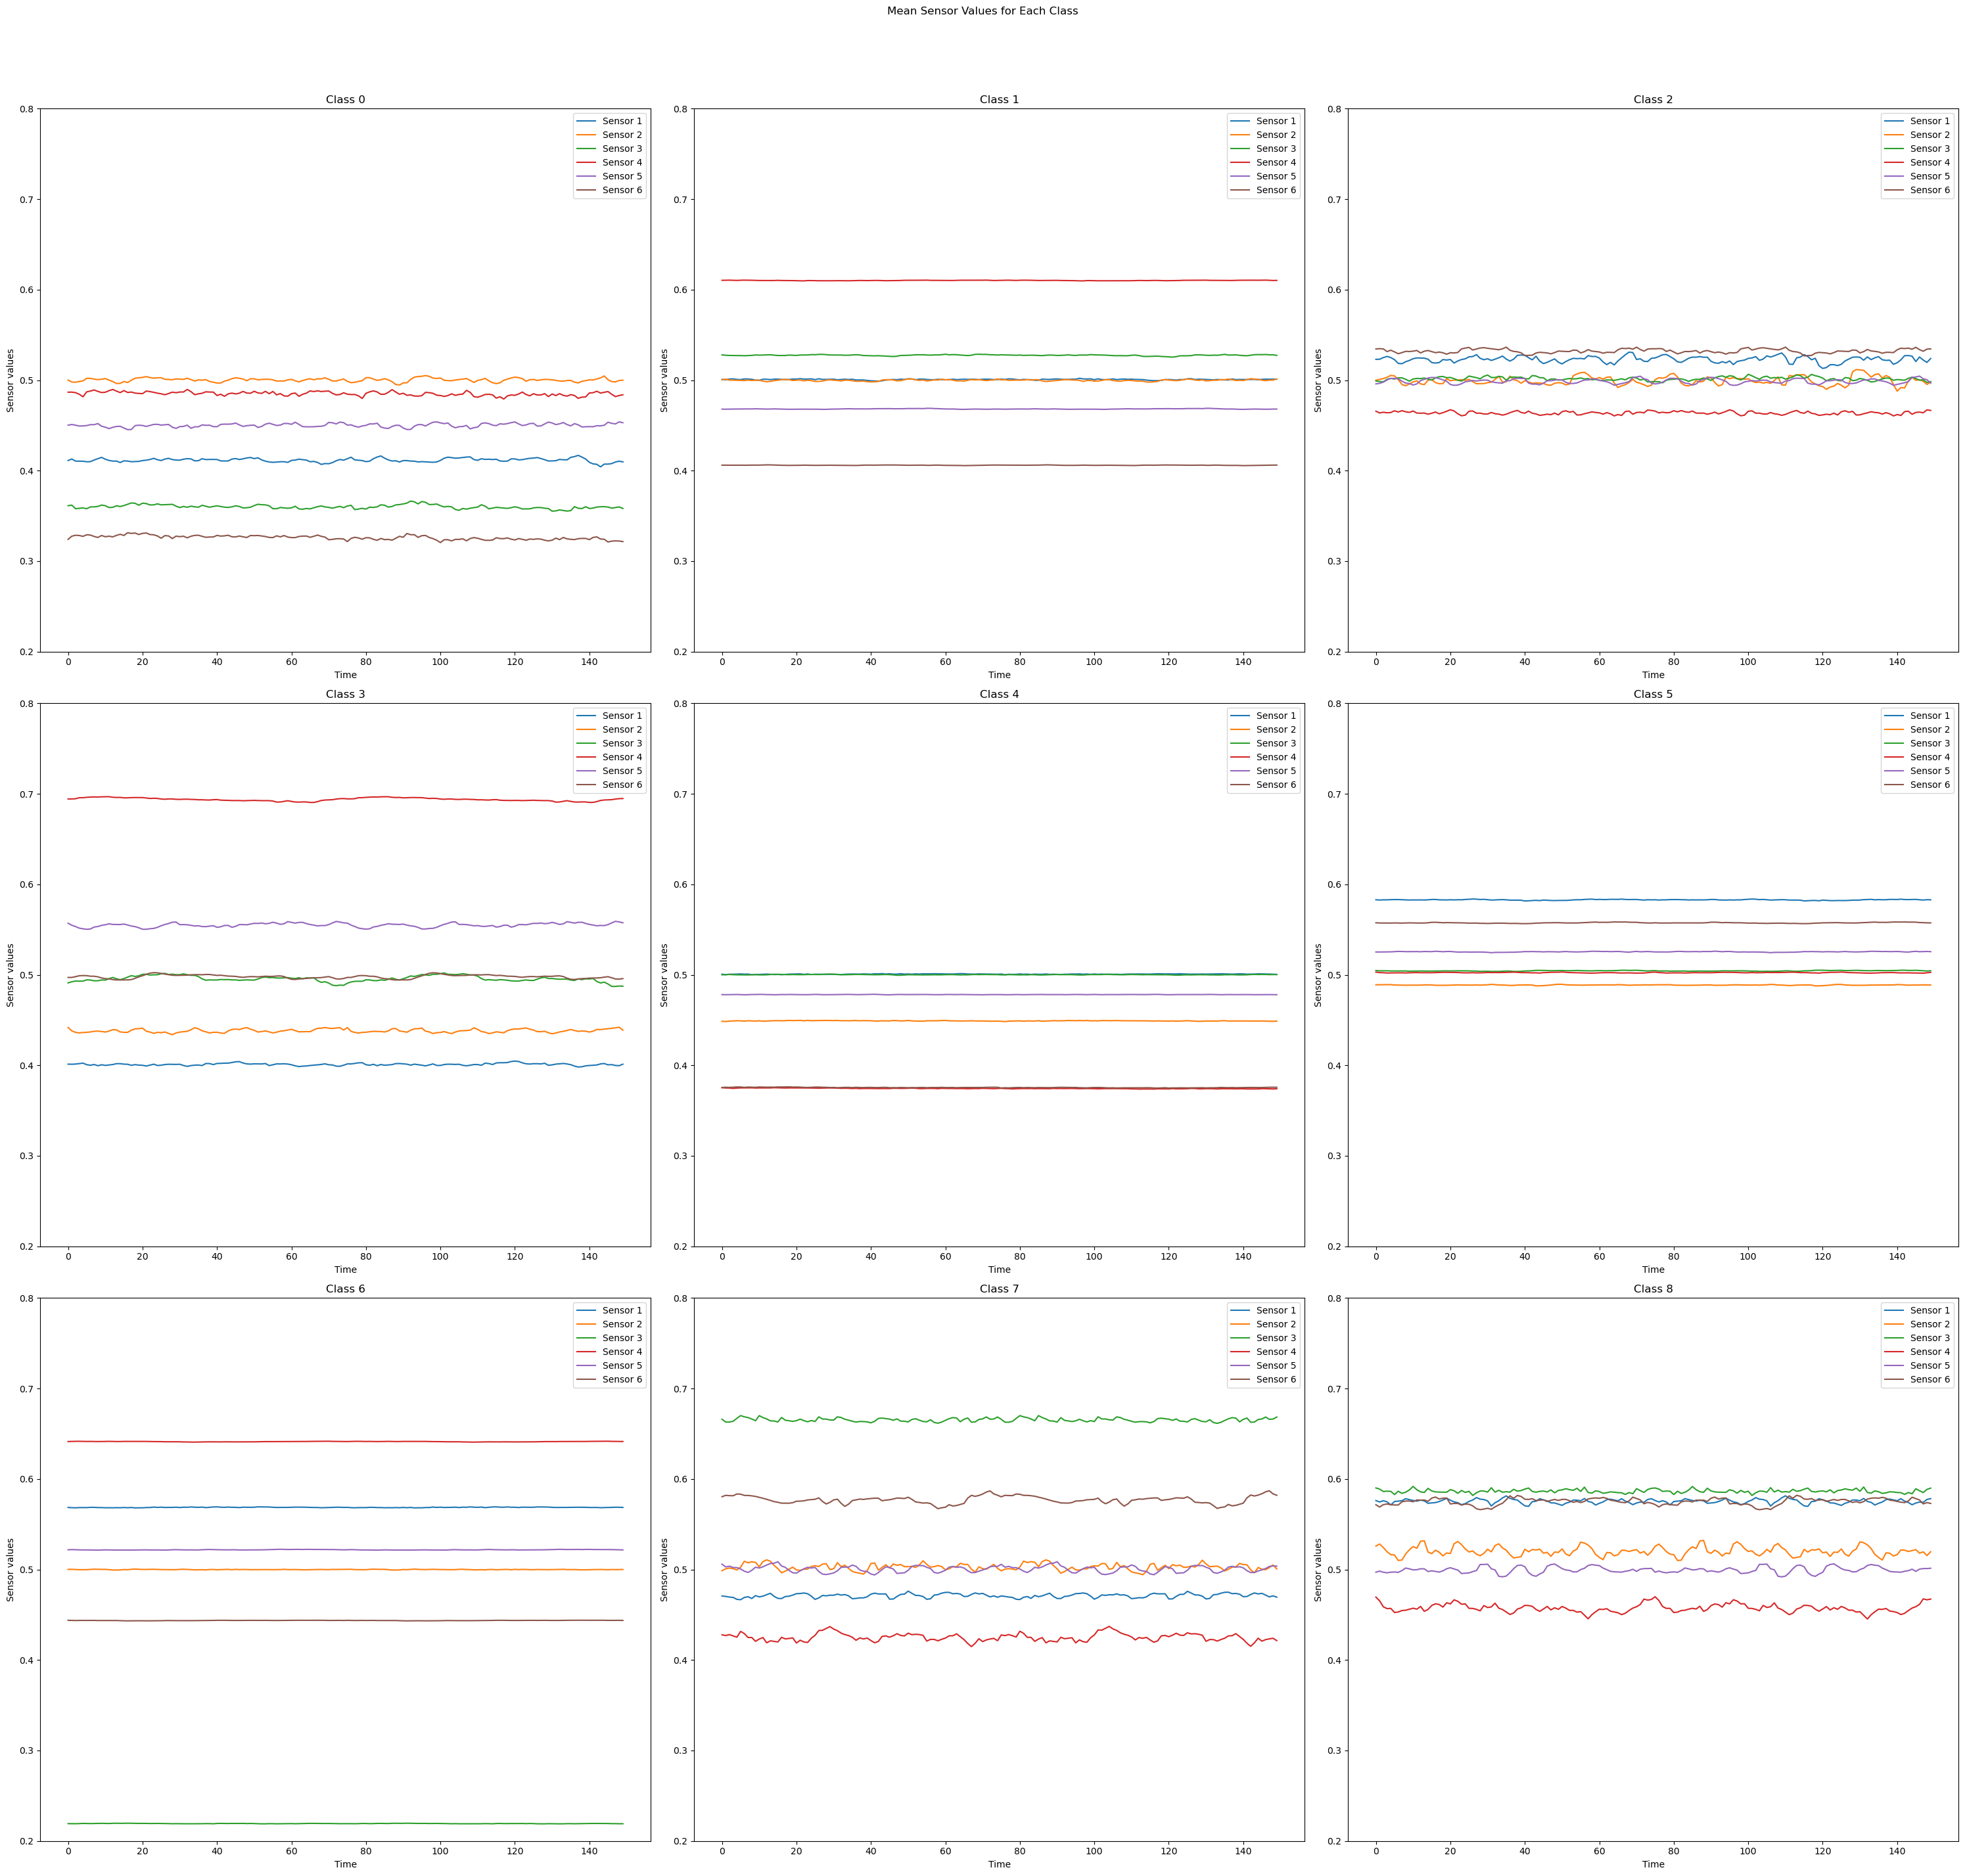

In [13]:
unique_classes = np.unique(merged_y_data)
num_axes = 6  # 6축 센서 데이터
num_rows = 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30,30))
fig.suptitle("Mean Sensor Values for Each Class")

for idx, cls in enumerate(unique_classes):
    row = idx // num_cols
    col = idx % num_cols

    ax = axes[row][col]  # 수정된 부분

    # 각 클래스별 인덱스 찾기
    class_indices = np.where(merged_y_data == cls)

    # 클래스별 데이터 추출
    class_data = merged_x_data[class_indices]

    # 각 센서 축별 평균값 계산 및 시각화
    for axis in range(num_axes):
        # 축별 데이터 추출
        axis_data = class_data[:, :, axis]

        # 평균값 계산
        mean_values = np.mean(axis_data, axis=0)

        # 평균값 시각화
        ax.plot(mean_values, label=f"Sensor {axis+1}")

    ax.set_title(f"Class {cls}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Sensor values")
    ax.set_ylim([0.2, 0.8])  # y축 범위 지정
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 서브플롯 간격 및 전체 플롯 제목 간격 조정
plt.show()


# 훈련, 테스트, 검증 데이터 나누기

In [14]:
def get_train_val_test_split(data_x, data_y):
    random_seed = 2021
    
    # 전체 데이터를 훈련 세트와 나머지(temp)로 80:20으로 분할
    x_train, x_temp, y_train, y_temp = train_test_split(data_x, data_y, test_size=0.4, shuffle=True, random_state=random_seed)
    
    # 나머지 데이터를 검증 세트와 테스트 세트로 50:50으로 분할 (전체 데이터의 10%씩)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=True, random_state=random_seed)

    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = get_train_val_test_split(merged_x_data, total_y_train)

# 결과 출력
print('X_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('X_test shape:', x_test.shape)

print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

X_train shape: (7531, 150, 6)
x_val shape: (2510, 150, 6)
X_test shape: (2511, 150, 6)
y_train shape: (7531, 9)
y_val shape: (2510, 9)
y_test shape: (2511, 9)


In [15]:
# x_train의 NaN 값을 확인합니다.
xtrain_count = np.isnan(x_train).sum()
ytrain_count = np.isnan(y_train).sum()
xtest_count = np.isnan(x_test).sum()
ytest_count = np.isnan(y_test).sum()
xval_count = np.isnan(x_val).sum()
yval_count = np.isnan(y_val).sum()

print(f"Number of NaN values in x_train: {xtrain_count}")
print(f"Number of NaN values in y_train: {ytrain_count}")
print(f"Number of NaN values in x_test: {xtest_count}")
print(f"Number of NaN values in y_test: {ytest_count}")
print(f"Number of NaN values in x_val: {xval_count}")
print(f"Number of NaN values in y_val: {yval_count}")

Number of NaN values in x_train: 0
Number of NaN values in y_train: 0
Number of NaN values in x_test: 0
Number of NaN values in y_test: 0
Number of NaN values in x_val: 0
Number of NaN values in y_val: 0


In [16]:
def onehot_to_labels(y_onehot):
    return np.argmax(y_onehot, axis=1)

def print_class_counts(y_onehot_data, dataset_name, class_names):
    y_labels = onehot_to_labels(y_onehot_data)
    unique, counts = np.unique(y_labels, return_counts=True)
    print(f"{dataset_name} 데이터 세트:")
    for label, count in zip(unique, counts):
        print(f"{class_names[label]}: {count}")
    print()

class_names = ['두 발로 서다','네 발로 서다', '걷다', '킁킁대다','뒷다리만 앉다', '엎드리다', '모든발이 앉다','놀다', '빠른걸음']

print_class_counts(y_train, "Train", class_names)
print_class_counts(y_val, "Validation", class_names)
print_class_counts(y_test, "Test", class_names)

Train 데이터 세트:
두 발로 서다: 229
네 발로 서다: 1433
걷다: 238
킁킁대다: 483
뒷다리만 앉다: 2251
엎드리다: 965
모든발이 앉다: 1639
놀다: 149
빠른걸음: 144

Validation 데이터 세트:
두 발로 서다: 74
네 발로 서다: 480
걷다: 70
킁킁대다: 189
뒷다리만 앉다: 726
엎드리다: 319
모든발이 앉다: 550
놀다: 48
빠른걸음: 54

Test 데이터 세트:
두 발로 서다: 76
네 발로 서다: 455
걷다: 89
킁킁대다: 153
뒷다리만 앉다: 770
엎드리다: 317
모든발이 앉다: 552
놀다: 51
빠른걸음: 48



# 데이터 증강

In [17]:
def add_noise(x, mean=0, std=0.1):
    noise = np.random.normal(mean, std, x.shape)
    x_noisy = x + noise
    return x_noisy

def mixup(x, y, alpha=1.0):
    assert len(x) == len(y)
    num_samples = len(x)
    
    # 람다 파라미터를 샘플링합니다.
    lmbda = np.random.beta(alpha, alpha, num_samples)
    
    # 랜덤으로 샘플 인덱스를 선택합니다.
    indices = np.random.permutation(num_samples)
    
    # 샘플링한 람다 파라미터로 새로운 데이터와 레이블을 만듭니다.
    x_mix = x * lmbda[:, np.newaxis, np.newaxis] + x[indices] * (1 - lmbda[:, np.newaxis, np.newaxis])
    y_mix = y * lmbda[:, np.newaxis] + y[indices] * (1 - lmbda[:, np.newaxis])
    
    return x_mix, y_mix

def get_class_indices(y, class_label):
    return np.where(np.argmax(y, axis=1) == class_label)[0]

def augment_class(x, y, class_label, augmentation_ratio, mixup_fn):
    class_indices = get_class_indices(y, class_label)
    num_samples = len(class_indices)
    num_augmented_samples = int(num_samples * augmentation_ratio)
    
    augmented_x = np.zeros((num_augmented_samples, *x.shape[1:]))
    augmented_y = np.zeros((num_augmented_samples, *y.shape[1:]))
    
    for i in range(0, num_augmented_samples, 2):
        mixed_x, mixed_y = mixup_fn(x[class_indices[i:i+2]], y[class_indices[i:i+2]])
        augmented_x[i] = mixed_x[0]
        augmented_y[i] = mixed_y[0]
    
    return augmented_x, augmented_y

def rotate_image(image, angle):
    height, width = image.shape[:2]
    image_center = (width // 2, height // 2)
    
    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_mat, (width, height))
    
    return rotated_image

def augment_class_rotation(x, y, class_label, num_rotations, angles):
    class_indices = get_class_indices(y, class_label)
    num_samples = len(class_indices)
    
    augmented_x = np.zeros((num_samples * num_rotations, *x.shape[1:]))
    augmented_y = np.zeros((num_samples * num_rotations, *y.shape[1:]))
    
    for i, index in enumerate(class_indices):
        for j, angle in enumerate(angles):
            rotated_image = rotate_image(x[index], angle)
            augmented_x[i * num_rotations + j] = rotated_image
            augmented_y[i * num_rotations + j] = y[index]
    
    return augmented_x, augmented_y

def augment_class_rotation_and_noise(x, y, class_label, num_rotations, angles, num_noisy_copies, noise_fn, mean=0, std=0.1):
    class_indices = get_class_indices(y, class_label)
    num_samples = len(class_indices)
    
    augmented_x = np.zeros((num_samples * num_rotations * num_noisy_copies, *x.shape[1:]))
    augmented_y = np.zeros((num_samples * num_rotations * num_noisy_copies, *y.shape[1:]))
    
    for i, index in enumerate(class_indices):
        for j, angle in enumerate(angles):
            rotated_image = rotate_image(x[index], angle)
            
            for k in range(num_noisy_copies):
                noisy_data = noise_fn(rotated_image, mean, std)
                augmented_x[i * num_rotations * num_noisy_copies + j * num_noisy_copies + k] = noisy_data
                augmented_y[i * num_rotations * num_noisy_copies + j * num_noisy_copies + k] = y[index]
    
    return augmented_x, augmented_y


def augment_class_noise(x, y, class_label, num_noisy_copies, noise_fn, mean=0, std=0.1):
    class_indices = get_class_indices(y, class_label)
    num_samples = len(class_indices)
    
    augmented_x = np.zeros((num_samples * num_noisy_copies, *x.shape[1:]))
    augmented_y = np.zeros((num_samples * num_noisy_copies, *y.shape[1:]))
    
    for i, index in enumerate(class_indices):
        for j in range(num_noisy_copies):
            noisy_data = noise_fn(x[index], mean, std)
            augmented_x[i * num_noisy_copies + j] = noisy_data
            augmented_y[i * num_noisy_copies + j] = y[index]
    
    return augmented_x, augmented_y

# 원하는 클래스에만 MixUp 증강을 적용합니다.
augmentation_ratio = 0.8
class_labels_to_augment = [0, 2, 3, 7, 8]
# 회전 증강을 적용합니다.
num_rotations = 2
angles = [180, 360]

num_noisy_copies = 2

# MixUp 증강을 적용합니다.
augmented_x_train_mixup = []
augmented_y_train_mixup = []

for class_label in class_labels_to_augment:
    class_augmented_x, class_augmented_y = augment_class(x_train, y_train, class_label, augmentation_ratio, mixup)
    augmented_x_train_mixup.append(class_augmented_x)
    augmented_y_train_mixup.append(class_augmented_y)

# 회전 증강을 적용합니다.
augmented_x_train_rotation = []
augmented_y_train_rotation = []

for class_label in class_labels_to_augment:
    class_augmented_x_rotation, class_augmented_y_rotation = augment_class_rotation(x_train, y_train, class_label, num_rotations, angles)
    augmented_x_train_rotation.append(class_augmented_x_rotation)
    augmented_y_train_rotation.append(class_augmented_y_rotation)

# 노이즈 증강을 적용합니다.
augmented_x_train_noise = []
augmented_y_train_noise = []

for class_label in class_labels_to_augment:
    class_augmented_x_noise, class_augmented_y_noise = augment_class_noise(x_train, y_train, class_label, num_noisy_copies, add_noise)
    augmented_x_train_noise.append(class_augmented_x_noise)
    augmented_y_train_noise.append(class_augmented_y_noise)

# MixUp 증강 데이터를 원래 훈련 데이터와 결합합니다.
augmented_x_train_mixup = np.concatenate(augmented_x_train_mixup, axis=0)
augmented_y_train_mixup = np.concatenate(augmented_y_train_mixup, axis=0)

x_train = np.concatenate([x_train, augmented_x_train_mixup], axis=0)
y_train = np.concatenate([y_train, augmented_y_train_mixup], axis=0)

# 회전 증강 데이터를 원래 훈련 데이터와 결합합니다.
augmented_x_train_rotation = np.concatenate(augmented_x_train_rotation, axis=0)
augmented_y_train_rotation = np.concatenate(augmented_y_train_rotation, axis=0)

x_train = np.concatenate([x_train, augmented_x_train_rotation], axis=0)
y_train = np.concatenate([y_train, augmented_y_train_rotation], axis=0)

# 노이즈 증강 데이터를 원래 훈련 데이터와 결합합니다.
augmented_x_train_noise = np.concatenate(augmented_x_train_noise, axis=0)
augmented_y_train_noise = np.concatenate(augmented_y_train_noise, axis=0)

x_train = np.concatenate([x_train, augmented_x_train_noise], axis=0)
y_train = np.concatenate([y_train, augmented_y_train_noise], axis=0)

In [18]:
def onehot_to_labels(y_onehot):
    return np.argmax(y_onehot, axis=1)

def print_class_counts(y_onehot_data, dataset_name, class_names):
    y_labels = onehot_to_labels(y_onehot_data)
    unique, counts = np.unique(y_labels, return_counts=True)
    print(f"{dataset_name} 데이터 세트:")
    for label, count in zip(unique, counts):
        print(f"{class_names[label]}: {count}")
    print()

print_class_counts(y_train, "Train", class_names)
print_class_counts(y_val, "Validation", class_names)
print_class_counts(y_test, "Test", class_names)

Train 데이터 세트:
두 발로 서다: 1732
네 발로 서다: 1433
걷다: 1285
킁킁대다: 2608
뒷다리만 앉다: 2251
엎드리다: 965
모든발이 앉다: 1639
놀다: 805
빠른걸음: 778

Validation 데이터 세트:
두 발로 서다: 74
네 발로 서다: 480
걷다: 70
킁킁대다: 189
뒷다리만 앉다: 726
엎드리다: 319
모든발이 앉다: 550
놀다: 48
빠른걸음: 54

Test 데이터 세트:
두 발로 서다: 76
네 발로 서다: 455
걷다: 89
킁킁대다: 153
뒷다리만 앉다: 770
엎드리다: 317
모든발이 앉다: 552
놀다: 51
빠른걸음: 48



# 모델 구성

In [19]:
torch.cuda.is_available()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [20]:
# Hyperparameters
batch_size = 8
learning_rate = 1e-6
num_epochs = 300

In [21]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

seed = 2023
set_seed(seed)

In [22]:
# 텐서로 변환
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)

x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

x_val = torch.tensor(x_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)

# 데이터 로더 생성
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)
val_data = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [23]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=(kernel_size - 1) // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 1, padding=(kernel_size - 1) // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # 입력 채널 수와 출력 채널 수가 다른 경우, 스킵 연결을 위해 1x1 컨볼루션 연산을 추가합니다
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self, x):
        # 입력을 스킵 연결로 사용하기 위해 저장
        identity = x
        # 첫 번째 컨볼루션 블록
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # 두 번째 컨볼루션 블록
        out = self.conv2(out)
        out = self.bn2(out)
        
        # 스킵 연결 추가
        identity = self.shortcut(identity)
        out += identity
        
        # 최종 출력값
        out = self.relu(out)
        return out

1. ResNet이 일반적으로 2차원 이미지 데이터를 처리하기 위해 설계되었기 때문에 1차원 시계열 데이터를 사용하는 경우, 데이터를 Resnet-lstm에 적합형태로 변환해야한다.

2. 이를 위해서 1차원 시계열 데이터를 2차원 이미지 형태로 변환해야한다. 보통 2차원 행렬로 만들거나 이미지 형태로 변환하는 과정을 포함한다.

In [29]:
 class ResNetLSTMClassificationModel(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(ResNetLSTMClassificationModel, self).__init__()

        # 자이로스코프 ResNet 블록
        self.resnet_gyro = nn.Sequential(
            ResidualBlock1D(3, 6, 5, stride=1),
            ResidualBlock1D(6, 12, 5, stride=1),
            ResidualBlock1D(12, 24, 5, stride=1)  # 추가된 부분
        )

        # 가속도계 ResNet 블록
        self.resnet_acc = nn.Sequential(
            ResidualBlock1D(3, 6, 5, stride=1),
            ResidualBlock1D(6, 12, 5, stride=1),
            ResidualBlock1D(12, 24, 5, stride=1)  # 추가된 부분
        )

        # 자이로스코프 LSTM
        self.lstm_gyro = nn.LSTM(24, 64, num_layers=2)  # input_size 변경: 12 -> 24
        self.tanh1 = nn.Tanh()

        # 가속도계 LSTM
        self.lstm_acc = nn.LSTM(24, 64, num_layers=2)  # input_size 변경: 12 -> 24
        self.tanh2 = nn.Tanh()

        self.fc1 = nn.Linear(128, 256)
        self.tanh3 = nn.Tanh()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.tanh4 = nn.Tanh()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 64)
        self.tanh5 = nn.Tanh()
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(64, output_shape)

    def forward(self, x):
        x_gyro = self.resnet_gyro(x[:, :, :3].transpose(1, 2))
        x_acc = self.resnet_acc(x[:, :, 3:].transpose(1, 2))

        x_gyro = x_gyro.transpose(1, 2)
        x_gyro, _ = self.lstm_gyro(x_gyro)
        x_gyro = self.tanh1(x_gyro[:, -1, :])

        x_acc = x_acc.transpose(1, 2)
        x_acc, _ = self.lstm_acc(x_acc)
        x_acc = self.tanh2(x_acc[:, -1, :])

        x_concat = torch.cat([x_gyro, x_acc], dim=1)
        x = self.tanh3(self.fc1(x_concat))
        x = self.dropout1(x)
        x = self.tanh4(self.fc2(x))
        x = self.dropout2(x)
        x = self.tanh5(self.fc3(x))
        x = self.dropout3(x)
        out = self.fc4(x)
        return out

1. 자이로스코프 ResNet 블록: 자이로스코프 데이터를 처리하는 1차원 ResNet 블록입니다. 두 개의 ResidualBlock1D 층으로 구성되어 있습니다. 각 층은 입력 채널 수, 출력 채널 수, 커널 크기 및 스트라이드를 매개변수로 지닌다.

2. 가속도계 ResNet 블록: 가속도계 데이터를 처리하는 1차원 ResNet 블록입니다. 두 개의 ResidualBlock1D 층으로 구성되어 있으며, 자이로스코프 ResNet 블록과 동일한 구조이다.

3. 자이로스코프 LSTM: 자이로스코프 데이터를 처리하는 LSTM 레이어입니다. 입력 크기는 12이고, 은닉 크기는 16이다.

4. 가속도계 LSTM: 가속도계 데이터를 처리하는 LSTM 레이어입니다. 입력 크기는 12이고, 은닉 크기는 16이다.

In [30]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [31]:
# Initialize model, loss function, and optimizer
input_shape = x_train.shape
output_shape = y_train.shape[1]
model = ResNetLSTMClassificationModel(input_shape, output_shape).to(device)
criterion = FocalLoss(alpha=1, gamma=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Initialize model, loss function, and optimizer
# input_shape = x_train.shape
# output_shape = y_train.shape[1]
# model = ResNetLSTMClassificationModel(input_shape, output_shape)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
print(input_shape)

torch.Size([13496, 150, 6])


In [33]:
train_losses = []
val_losses = []
val_accuracies = []

# Early stopping parameters
patience = 20
n_epochs_stop = 0
min_val_loss = np.Inf
stop = False

for epoch in range(num_epochs):
    if stop:
        break

    running_train_loss = 0.0
    running_val_loss = 0.0
    
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = torch.argmax(labels, dim=1)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            labels_argmax = torch.argmax(labels, dim=1)

            outputs = model(inputs)

            loss = criterion(outputs, labels_argmax)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels_argmax.size(0)
            correct_val += (predicted == labels_argmax).sum().item()

            running_val_loss += loss.item()

    train_losses.append(running_train_loss / len(train_loader))
    val_losses.append(running_val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1]}%')
    
    # Early stopping logic
    if val_losses[-1] < min_val_loss:
        min_val_loss = val_losses[-1]
        n_epochs_stop = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        n_epochs_stop += 1

    if n_epochs_stop >= patience:
        print('Early stopping!')
        stop = True

print('Finished Training')

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))


Epoch 1, Train Loss: 1.7276344858264527, Validation Loss: 1.701759878996831, Validation Accuracy: 2.948207171314741%
Epoch 2, Train Loss: 1.7218379879676171, Validation Loss: 1.6972647635800064, Validation Accuracy: 2.948207171314741%
Epoch 3, Train Loss: 1.7151810012064392, Validation Loss: 1.6911608599553443, Validation Accuracy: 2.948207171314741%
Epoch 4, Train Loss: 1.7075736909910426, Validation Loss: 1.6842976842716242, Validation Accuracy: 2.9880478087649402%
Epoch 5, Train Loss: 1.700739275794377, Validation Loss: 1.6782501810675214, Validation Accuracy: 14.422310756972111%
Epoch 6, Train Loss: 1.6920236322960347, Validation Loss: 1.6700510386448757, Validation Accuracy: 24.223107569721115%
Epoch 7, Train Loss: 1.682454917935415, Validation Loss: 1.6599402966772674, Validation Accuracy: 28.96414342629482%
Epoch 8, Train Loss: 1.6752176477701337, Validation Loss: 1.6515858105033825, Validation Accuracy: 24.02390438247012%
Epoch 9, Train Loss: 1.6657419872481793, Validation Loss

<All keys matched successfully>

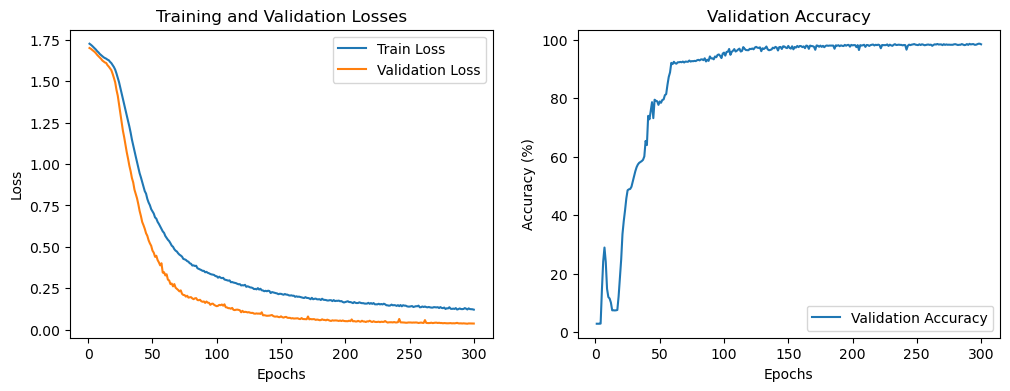

In [34]:
epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.show()

In [35]:
# 모델을 평가 모드로 설정
model.eval()

# 정확도 계산을 위한 변수 초기화
correct = 0
total = 0

# 예측값과 실제 라벨을 저장할 리스트 초기화
y_true = []
y_pred = []

with torch.no_grad():
    for data, labels in test_loader:
        # 데이터를 모델에 전달하여 예측값 계산
        outputs = model(data)
        
        # 예측값 중 가장 높은 확률을 가진 클래스를 선택
        _, predicted = torch.max(outputs.data, 1)

        # 원-핫 인코딩된 라벨을 정수 형태로 변환
        labels = torch.argmax(labels, dim=1)

        # 정답과 예측값을 비교하여 정확도 계산
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 예측값과 실제 라벨을 리스트에 추가
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# 테스트 데이터에 대한 정확도 출력
print('Test Accuracy: %d%%' % (100 * correct / total))

# 클래스별 정밀도, 재현율, F-1 점수 계산
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# 클래스별 정밀도, 재현율, F-1 점수 출력
for i, (p, r, f) in enumerate(zip(precision, recall, fscore)):
    print(f"Class {i}: Precision={p:.2f}, Recall={r:.2f}, F1-score={f:.2f}")

# 테스트 데이터에 대한 가중치 평균 F1-score 출력
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
print('Weighted Test F1-Score: %.2f' % weighted_f1)

Test Accuracy: 98%
Class 0: Precision=1.00, Recall=0.99, F1-score=0.99
Class 1: Precision=0.99, Recall=0.98, F1-score=0.99
Class 2: Precision=0.93, Recall=0.94, F1-score=0.94
Class 3: Precision=0.94, Recall=0.99, F1-score=0.96
Class 4: Precision=0.99, Recall=1.00, F1-score=1.00
Class 5: Precision=1.00, Recall=0.99, F1-score=1.00
Class 6: Precision=1.00, Recall=1.00, F1-score=1.00
Class 7: Precision=0.96, Recall=0.96, F1-score=0.96
Class 8: Precision=0.98, Recall=0.98, F1-score=0.98
Weighted Test F1-Score: 0.99


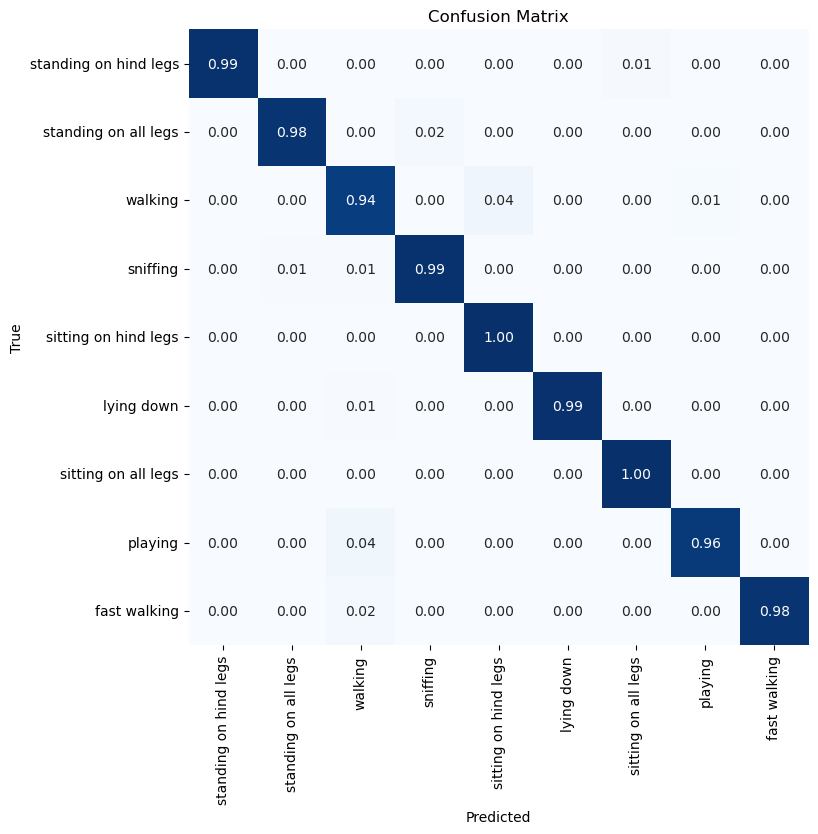

In [36]:
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        true_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)

# Confusion Matrix 시각화 함수 정의
def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(8, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# 클래스 이름 자동 할당
class_names = ["standing on hind legs", "standing on all legs", "walking", "sniffing", "sitting on hind legs", "lying down", "sitting on all legs", "playing", "fast walking"]
#"두 발로 서다", "네 발로 서다", "걷다", "킁킁대다", "뒷다리만 앉다", "엎드리다", "모든 발이 앉다", "놀다", "빠른걸음"

# Confusion Matrix 정규화
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Confusion Matrix 시각화
plot_confusion_matrix(normalized_cm, class_names)